# Отток клиентов

## Введение

### Задание

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

### Описание данных

- **RowNumber** — индекс строки в данных
- **CustomerId** — уникальный идентификатор клиента
- **Surname** — фамилия
- **CreditScore** — кредитный рейтинг
- **Geography** — страна проживания
- **Gender** — пол
- **Age** — возраст
- **Tenure** — количество недвижимости у клиента
- **Balance** — баланс на счёте
- **NumOfProducts** — количество продуктов банка, используемых клиентом
- **HasCrCard** — наличие кредитной карты
- **IsActiveMember** — активность клиента
- **EstimatedSalary** — предполагаемая зарплата

Целевой признак
- **Exited** — факт ухода клиента

## Подключение библиотек

In [1]:
#import warnings
#warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import normaltest

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

## Подготовка данных

In [2]:
data = pd.read_csv('/datasets/Churn.csv')

In [3]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


### Вывод 

- Поле **Tenure** содержит пустые значения 
- Поля **Surname**, **Geography**, **Gender** не числовые
- Предположительно поля **RowNumber**, **CustomerId**, **Surname**, **Geography**, **Gender** не влиют на результат 

## Кодирование признаков 

Поля Surname, Geography, Gender — являются категориальными признаками и мы решаем задачу классификации, поэтому нам подойдет кодировка OrdinalEncoder

In [5]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [6]:
encoder = OrdinalEncoder()
encoder.fit(data[['Surname', 'Geography', 'Gender']])
data[['Surname', 'Geography', 'Gender']] = encoder.transform(data[['Surname', 'Geography', 'Gender']])

In [7]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,1115.0,619,0.0,0.0,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,1177.0,608,2.0,0.0,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,2040.0,502,0.0,0.0,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,289.0,699,0.0,0.0,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,1822.0,850,2.0,0.0,43,2.0,125510.82,1,1,1,79084.10,0


## Удаление полей не влияющих на результат

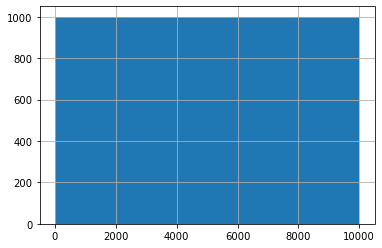

In [8]:
data['RowNumber'].hist()

Поле распределено равномерно, точно не влияет на результат

In [9]:
data = data.drop('RowNumber', axis=1)

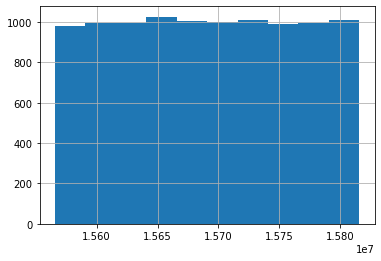

In [10]:
data['CustomerId'].hist()

Поле распределено равномерно, точно не влияет на результат

In [11]:
data = data.drop('CustomerId', axis=1)

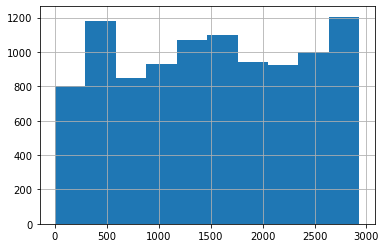

In [12]:
data['Surname'].hist()

Распределение почти равномерное, скорее всего поле Surname не влияет на результат.

In [13]:
data = data.drop('Surname', axis=1)

In [14]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0.0,0.0,42,2.0,0.00,1,1,1,101348.88,1
1,608,2.0,0.0,41,1.0,83807.86,1,0,1,112542.58,0
2,502,0.0,0.0,42,8.0,159660.80,3,1,0,113931.57,1
3,699,0.0,0.0,39,1.0,0.00,2,0,0,93826.63,0
4,850,2.0,0.0,43,2.0,125510.82,1,1,1,79084.10,0


## Поиск и обработка выбивающихся значений 

In [15]:
def normal_test(data):
    stat, p = normaltest(data)
    alpha = 0.05
    if p > alpha:
        print('Данные распределены нормально (Принимаем H0)')
    else:
        print('Данные распределены не нормально (Отвергаем H0)')

### Поле CreditScore

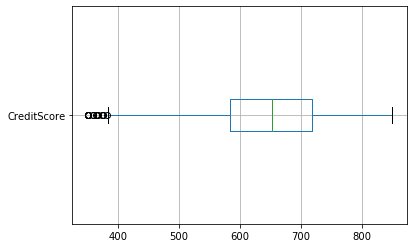

In [18]:
data.boxplot('CreditScore', vert=False)

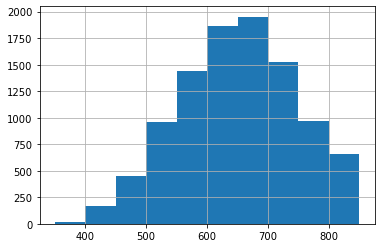

In [19]:
data['CreditScore'].hist()

## Деление выборки

In [17]:
aWSDAEADFG

NameError: name 'aWSDAEADFG' is not defined

### Заполнение Tenure

In [ ]:
def find_importances(X, Y, header):
    
    model = ExtraTreesClassifier()
    model.fit(X, Y)
    
    result = []
    for feat, importance in zip(header, model.feature_importances_):  
        temp = [feat, importance]
        result.append(temp)

    data = pd.DataFrame(result, columns = ['Feature', 'Importance'])
    return data.sort_values('Importance', ascending = False)
    

In [ ]:
def split_x_y(data):
    X = data.drop('Tenure', axis=1)
    Y = data['Tenure']
    return X, Y

In [ ]:
tenure_train = data_train[data_train['Tenure'].notna()] 

tenure_train_x, tenure_train_y = split_x_y(tenure_train)

# feature extraction
importances = find_importances(tenure_train_x, tenure_train_y, tenure_train_x.columns)
importances

In [ ]:
def get_importances_columns(data, threshold):
    return data[data['Importance'] > threshold]['Feature'].values

In [ ]:
columns = get_importances_columns(importances, 0.1)
columns

In [ ]:
columns = ['EstimatedSalary', 'CreditScore', 'Age', 'Balance']
tenure_train_x = tenure_train_x[columns]

In [ ]:
tenure_valid = data_test[data_test['Tenure'].notna()] 

tenure_valid_x, tenure_valid_y = split_x_y(tenure_valid) 

tenure_valid_x = ordinal_encoder(tenure_valid_x)
tenure_valid_x = tenure_valid_x[columns]

In [ ]:
best_model_random_forest = None
best_accuracy = 0
best_est = 0
best_depth = 0
for est in range(1, 200, 20):
    for depth in range (1, 30):
        
        model = RandomForestClassifier(random_state=12345, n_estimators=est ,max_depth=depth)
        model.fit(tenure_train_x, tenure_train_y)
        
        predictions = model.predict(tenure_valid_x)
        result = accuracy_score(predictions, tenure_valid_y)
        
        if result > best_accuracy:
            best_model_random_forest = model
            best_accuracy = result
            best_est = est
            best_depth = depth

In [ ]:
best_accuracy

In [ ]:
best_depth

## Исследование задачи

## Борьба с дисбалансом

## Тестирование модели

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: задача исследована
    - [ ]  Исследован баланс классов
    - [ ]  Изучены модели без учёта дисбаланса
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 3: учтён дисбаланс
    - [ ]  Применено несколько способов борьбы с дисбалансом
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 4: проведено тестирование
- [ ]  Удалось достичь *F1*-меры не менее 0.59
- [ ]  Исследована метрика *AUC-ROC*